In [40]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns # Import seaborn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#!pip install torch # install torch library
import torch as t  # Import and alias torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
#uploaded = files.upload()

# Uploading Data
# filename = list(uploaded.keys())[0]
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
df = pd.read_csv('DT3.csv')
# Ensure data loaded correctly
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Data exploration

In [41]:
# Identifying repeating Patient_ID
duplicate_counts = df["patient_id"].value_counts()
repeated_ids = duplicate_counts[duplicate_counts > 1]

if not repeated_ids.empty:
    print("There are repeating Patient_IDs:")
    print(repeated_ids)
else:
    print("No repeating Patient_IDs found.")

No repeating Patient_IDs found.


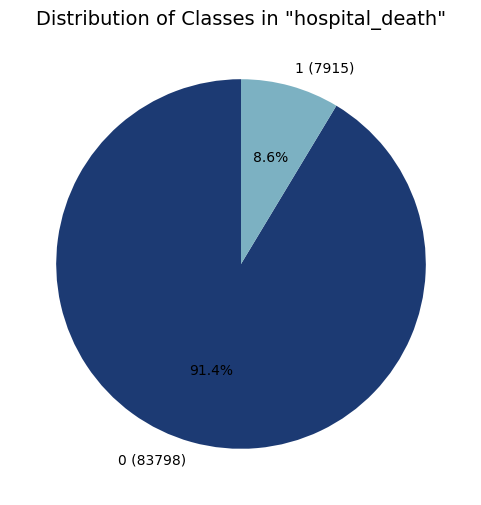

In [42]:
# Checking class imbalance in target variable = hospital_death

counts = df['hospital_death'].value_counts()

# Colour Scheme
colors = ['#1c3a73', '#7cb1c2']

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=[f'{cls} ({count})' for cls, count in counts.items()],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
plt.title('Distribution of Classes in "hospital_death"', fontsize=14)
plt.show()

In [43]:
# Create a new variable 'Comorbidities' based on the specified conditions
df['Comorbidities'] = 0
df.loc[df['aids'] == 1, 'Comorbidities'] = 1
df.loc[df['cirrhosis'] == 1, 'Comorbidities'] = 1
df.loc[df['diabetes_mellitus'] == 1, 'Comorbidities'] = 1
df.loc[df['hepatic_failure'] == 1, 'Comorbidities'] = 1
df.loc[df['immunosuppression'] == 1, 'Comorbidities'] = 1
df.loc[df['leukemia'] == 1, 'Comorbidities'] = 1
df.loc[df['lymphoma'] == 1, 'Comorbidities'] = 1
df.loc[df['solid_tumor_with_metastasis'] == 1, 'Comorbidities'] = 1


In [44]:
# Investiage missingness
variable_list = ['age', 'bmi', 'ethnicity'	, 'gender',	'elective_surgery', 'pre_icu_los_days','readmission_status', 'Comorbidities','apache_2_diagnosis',
'apache_3j_diagnosis','creatinine_apache','glucose_apache','heart_rate_apache','map_apache','ventilated_apache','d1_bun_max','d1_bun_min','d1_creatinine_max','d1_glucose_max','d1_glucose_min',
'resprate_apache']

for variable in variable_list:
    zeros = len(df[df[variable] == 0])
    print(f"The total number of individuals with {variable} == 0 is: {zeros}")
    missing = len(df[df[variable].isnull()])
    print(f"The total number of individuals with {variable} == missing is: {missing}")

The total number of individuals with age == 0 is: 0
The total number of individuals with age == missing is: 4228
The total number of individuals with bmi == 0 is: 0
The total number of individuals with bmi == missing is: 3429
The total number of individuals with ethnicity == 0 is: 0
The total number of individuals with ethnicity == missing is: 1395
The total number of individuals with gender == 0 is: 0
The total number of individuals with gender == missing is: 25
The total number of individuals with elective_surgery == 0 is: 74862
The total number of individuals with elective_surgery == missing is: 0
The total number of individuals with pre_icu_los_days == 0 is: 3711
The total number of individuals with pre_icu_los_days == missing is: 0
The total number of individuals with readmission_status == 0 is: 91713
The total number of individuals with readmission_status == missing is: 0
The total number of individuals with Comorbidities == 0 is: 66416
The total number of individuals with Comorb

In [45]:
# Ensure categorical variables are encoded as numeric
df.dtypes
df_encoded = df.copy()
categorical_columns = ['ethnicity'	, 'gender',	'elective_surgery', 'readmission_status', 'Comorbidities','ventilated_apache']

# Encode categorical variables as numeric
for col in categorical_columns:
    df_encoded[col] = pd.factorize(df_encoded[col])[0]

In [46]:
# Select only the predictor variables (exclude the target variable if present)
predictors = df_encoded[[
'age', 'bmi', 'ethnicity'	, 'gender',	'elective_surgery', 'pre_icu_los_days','readmission_status', 'Comorbidities',
'apache_2_diagnosis', 'apache_3j_diagnosis','creatinine_apache','glucose_apache','heart_rate_apache','map_apache',
'ventilated_apache','d1_bun_max','d1_bun_min','d1_creatinine_max','d1_glucose_max','d1_glucose_min',
'resprate_apache']]

# Replace infinite values with NaN
predictors = predictors.replace([np.inf, -np.inf], np.nan)

# Drop rows with any missing values
predictors = predictors.dropna()

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Display the VIF results
print(vif_data)
#d1_creatinine_max ,d1_glucose_max

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


               Variable         VIF
0                   age   13.093043
1                   bmi   11.604130
2             ethnicity    1.217144
3                gender    1.870945
4      elective_surgery    3.685641
5      pre_icu_los_days    1.175822
6    readmission_status         NaN
7         Comorbidities    3.546901
8    apache_2_diagnosis    6.703922
9   apache_3j_diagnosis    7.478114
10    creatinine_apache  159.270775
11       glucose_apache   32.602349
12    heart_rate_apache   10.988638
13           map_apache    5.227544
14    ventilated_apache    1.690461
15           d1_bun_max   45.319682
16           d1_bun_min   41.811127
17    d1_creatinine_max  164.327059
18       d1_glucose_max   37.575763
19       d1_glucose_min   13.150198
20      resprate_apache    4.194702


In [47]:
# Remove features with VIF > 10
predictors = df_encoded[[
'age', 'bmi', 'ethnicity'	, 'gender',	'elective_surgery', 'pre_icu_los_days','readmission_status', 'Comorbidities',
'apache_2_diagnosis', 'apache_3j_diagnosis','creatinine_apache','glucose_apache','heart_rate_apache','map_apache',
'ventilated_apache','d1_bun_min','resprate_apache']]

# Replace infinite values with NaN
predictors = predictors.replace([np.inf, -np.inf], np.nan)

# replace missing values with -1
predictors = predictors.fillna(-1)

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Display the VIF results
print(vif_data)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


               Variable       VIF
0                   age  7.862974
1                   bmi  7.401705
2             ethnicity  1.195365
3                gender  1.860505
4      elective_surgery  3.268018
5      pre_icu_los_days  1.157799
6    readmission_status       NaN
7         Comorbidities  3.447267
8    apache_2_diagnosis  6.091494
9   apache_3j_diagnosis  6.656340
10    creatinine_apache  2.206168
11       glucose_apache  3.540967
12    heart_rate_apache  9.876891
13           map_apache  5.150120
14    ventilated_apache  1.568753
15           d1_bun_min  3.559697
16      resprate_apache  4.101096


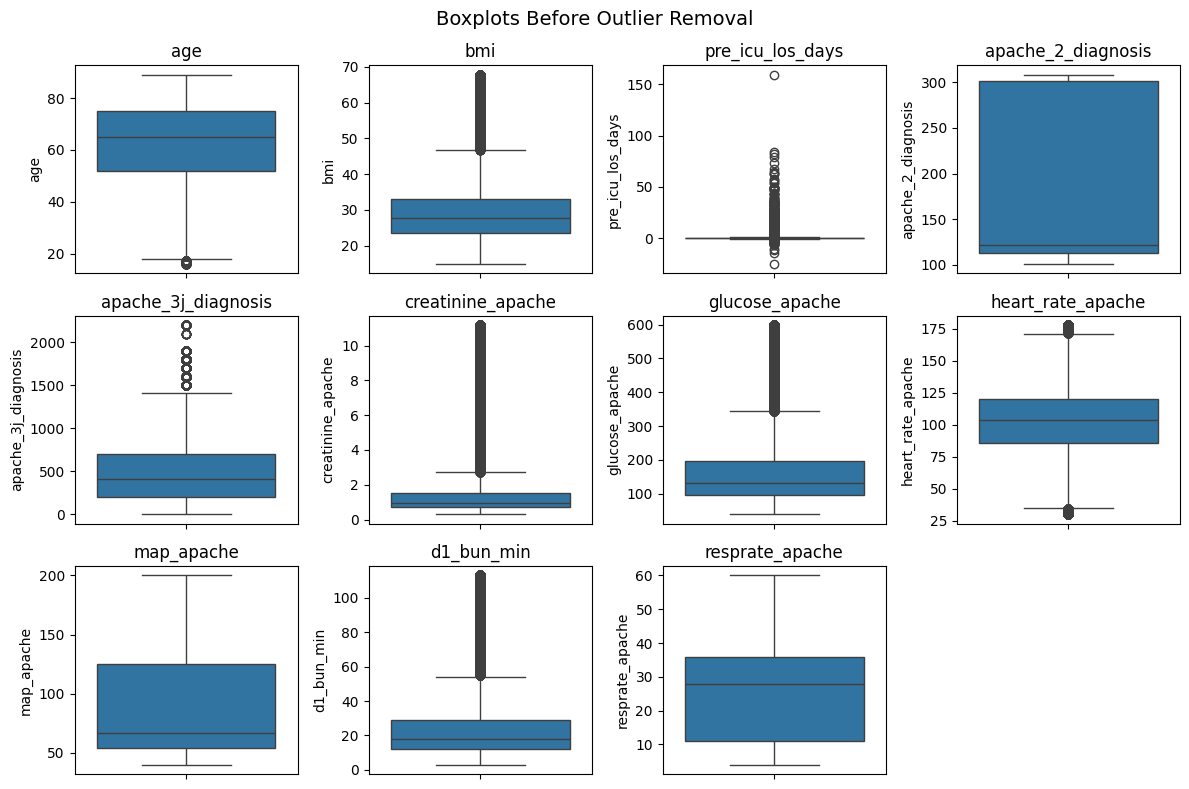

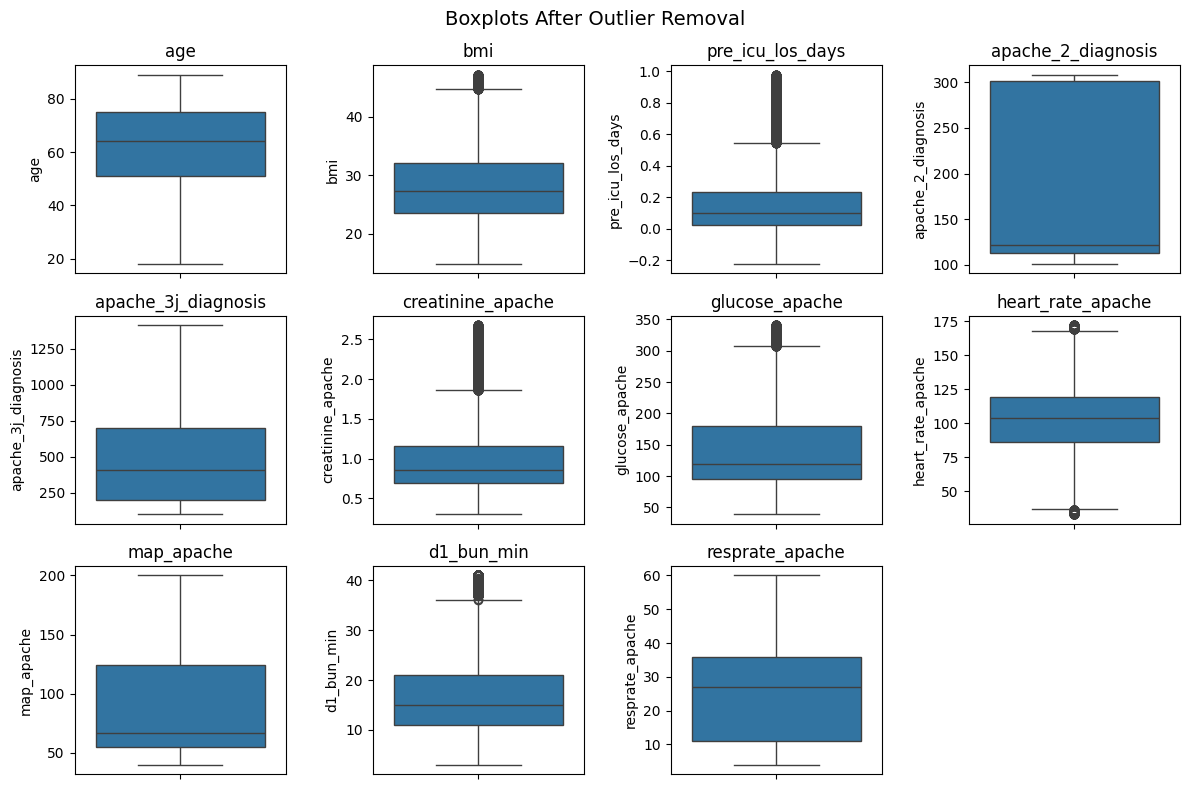

In [48]:
# Continuous vars: Identify outliers using boxplots, remove outliers outside of IQR
continuous_vars = ['age', 'bmi', 'pre_icu_los_days',
'apache_2_diagnosis', 'apache_3j_diagnosis','creatinine_apache','glucose_apache','heart_rate_apache','map_apache',
'd1_bun_min','resprate_apache']

# Define Function to create boxplots
def plot_boxplots(df, title):
    num_plots = len(continuous_vars)
    num_cols = 4  # You can adjust this if needed
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows dynamically

    plt.figure(figsize=(12, 8))
    for i, col in enumerate(continuous_vars, 1):
        if col in df.columns:
            plt.subplot(num_rows, num_cols, i) # Use calculated rows and columns
            sns.boxplot(y=df[col])
            plt.title(col)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Define function to remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Plot boxplots before removing outliers
plot_boxplots(df, "Boxplots Before Outlier Removal")

# Apply the function to remove outliers
df = remove_outliers(df, continuous_vars)

# Plot boxplots after removing outliers
plot_boxplots(df, "Boxplots After Outlier Removal")

In [49]:
#Catergorical: Check for sparsity (count and %)
cat_vars = ['ethnicity'	, 'gender',	'elective_surgery', 'readmission_status', 'Comorbidities',
'ventilated_apache','resprate_apache']

# Define function to calculate counts and percentages
def get_counts_and_percentages(df, var):
    counts = df[var].value_counts().reset_index()
    counts.columns = [var, 'count']
    counts['percentage'] = (counts['count'] / counts['count'].sum()) * 100
    return counts

results = {var: get_counts_and_percentages(df, var) for var in cat_vars}
for var, result in results.items():
    print(f"Results for {var}:")
    print(result)
    print("\n")

Results for ethnicity:
          ethnicity  count  percentage
0         Caucasian  30563   79.535223
1  African American   3494    9.092565
2     Other/Unknown   1987    5.170843
3          Hispanic   1559    4.057043
4             Asian    490    1.275145
5   Native American    334    0.869181


Results for gender:
  gender  count  percentage
0      M  21461   55.070567
1      F  17509   44.929433


Results for elective_surgery:
   elective_surgery  count  percentage
0                 0  33121   84.977935
1                 1   5855   15.022065


Results for readmission_status:
   readmission_status  count  percentage
0                   0  38976       100.0


Results for Comorbidities:
   Comorbidities  count  percentage
0              0  29596   75.933908
1              1   9380   24.066092


Results for ventilated_apache:
   ventilated_apache  count  percentage
0                0.0  26706   68.519089
1                1.0  12270   31.480911


Results for resprate_apache:
    resprate

In [50]:
# Encoding 'Sex' and 'ethnicity' variables
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['gender'])  # Male: 1, Female: 0
df['ethnicity_encoded'] = le.fit_transform(df['ethnicity'])# missing as a sepearte column

In [51]:
#Final Dataset for Model
columns_to_keep = ['hospital_death',
'age', 'bmi', 'ethnicity_encoded'	, 'Sex',	'elective_surgery', 'pre_icu_los_days','readmission_status', 'Comorbidities',
'apache_2_diagnosis', 'apache_3j_diagnosis','creatinine_apache','glucose_apache','heart_rate_apache','map_apache',
'ventilated_apache','d1_bun_min','resprate_apache']

df2 = df[columns_to_keep]

#Check for missingness
print(df2.isnull().sum())

hospital_death         0
age                    0
bmi                    0
ethnicity_encoded      0
Sex                    0
elective_surgery       0
pre_icu_los_days       0
readmission_status     0
Comorbidities          0
apache_2_diagnosis     0
apache_3j_diagnosis    0
creatinine_apache      0
glucose_apache         0
heart_rate_apache      0
map_apache             0
ventilated_apache      0
d1_bun_min             0
resprate_apache        0
dtype: int64


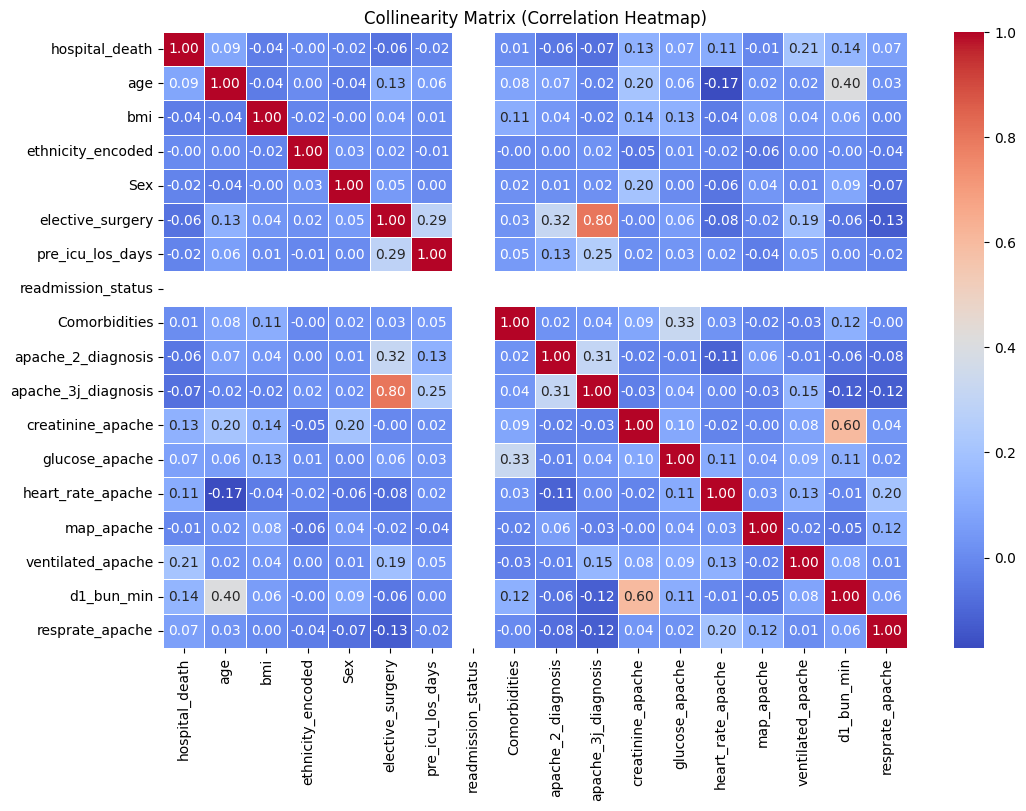

In [52]:
# Compute the correlation matrix
corr_matrix = df2.corr()

plt.figure(figsize=(12, 8))

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Collinearity Matrix (Correlation Heatmap)")
plt.show()

Model

In [55]:
# Randomly sample 70% of the df for training
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df2, test_size=0.3, random_state=42)
# Use the remaining 30% for testing
test_data, val_data = train_test_split(test_data, test_size=1/3, random_state=42)

class_1_weight = len(train_data[train_data['hospital_death'] == 0]) / len(train_data[train_data['hospital_death'] == 1])
# Check the mean of the 'hospital_death' column in both training and testing data
print(train_data['hospital_death'].value_counts())
print(test_data['hospital_death'].value_counts())
print(val_data['hospital_death'].value_counts())

# Data Preparation

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = train_data['hospital_death'].to_numpy()
Y_test = test_data['hospital_death'].to_numpy()
Y_val = val_data['hospital_death'].to_numpy()

# Extract the features (excluding 'DEATH_EVENT') for training and testing
X_train = train_data.drop('hospital_death', axis=1).to_numpy()
X_test = test_data.drop('hospital_death', axis=1).to_numpy()
X_val = val_data.drop('hospital_death', axis=1).to_numpy()

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

hospital_death
0    25684
1     1599
Name: count, dtype: int64
hospital_death
0    7341
1     454
Name: count, dtype: int64
hospital_death
0    3676
1     222
Name: count, dtype: int64


In [62]:
class PredictiveNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(PredictiveNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer with batch normalization
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.BatchNorm1d(hidden_sizes[0])) # Batch normalization
        self.layers.append(nn.Tanh())

        # Hidden layers with batch normalization
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.BatchNorm1d(hidden_sizes[i+1])) # Batch normalization
            self.layers.append(nn.ReLU())
            if i == len(hidden_sizes) - 2: self.layers.append(nn.Dropout(dropout_rate))

        # Output layer (no batch normalization typically)
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            #Reshape for batchnorm
            if isinstance(layer, nn.BatchNorm1d):
                x = layer(x.view(x.size(0), -1))
            else:
                x = layer(x)
        return x

In [63]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score
from tqdm import tqdm
import torch.nn as nn
# Regularization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define hyperparameters
number_of_input_features = 17 ##number of features
number_of_hidden_units = 5 ##how many layer
epochs = 15 ##number of times our network sees our training set
learning_rate = 0.001
batch_size = 32 #smaller less run time use/try diiferent and check convergence

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

X_val_tensor = t.Tensor(X_val).type(t.float32)
Y_val_tensor = t.Tensor(Y_val).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model with regularization
# model = nn.Sequential(
#     nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
#     nn.Tanh(),  # Tanh activation function
#     nn.Linear(number_of_hidden_units, 1),  # Another linear layer
#     nn.Sigmoid()  # Sigmoid activation for probability output
# )

# Define the optimizer
# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_1_weight], device=device))
model = PredictiveNeuralNetwork(number_of_input_features, [32, 10], 1)
# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# for epoch in range(epochs):

#     per_epoch_loss_list = []

#     for batch_idx, (X, Y) in enumerate(train_data_loader):
#         # Forward pass: Compute predictions
#         probs = model(X)

#         # Adding regularization term for all parameters in the model
#         l2_term = sum([(w ** 2).sum() for w in model.parameters()])

#         # New loss is the old loss + regularization term
#         loss = loss_fn(probs.view(-1), Y) + landa * l2_term

#         per_epoch_loss_list.append(loss.item())

#         # Backward pass: Compute gradient and update weights
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Evaluate the model on training and validation data
#     with t.no_grad():
#         # Set the model in eval mode; some layers use this for certain calculations during training
#         model.eval()

#         # Calculate accuracy on train data
#         probs = model(X_train_tensor)
#         prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
#         train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

#         # Calculate accuracy on validation data
#         probs = model(X_test_tensor)
#         prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
#         validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

#         # Print accuracy for the current epoch
#         print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

#         # Set the model back to train mode
#         model.train()

#         # Append accuracy values to lists
#         train_accuracy_list.append(train_accuracy)
#         validation_accuracy_list.append(validation_accuracy)

#     # Calculate and append the average loss for the epoch
#     train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

cuda


In [66]:
#import f1
from sklearn.metrics import f1_score
all_f1s = []
def train_model(model, train_loader, val_loader, epochs=10, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_1_weight], device=device))

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Wrap train_loader with tqdm for dynamic progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)  # Ensure correct shape

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {avg_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        all_predictions = []
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Validation {epoch+1}/{epochs}", leave=False)
            for inputs, targets in progress_bar:
                inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                predictions = (outputs >= 0.5).type(t.LongTensor).view(-1)
                all_predictions.extend(predictions.cpu().numpy())
                loss = loss_fn(outputs, targets)

                val_loss += loss.item()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_val_loss = val_loss / len(val_loader)
        total_accuracy = accuracy_score(Y_val_tensor.cpu().numpy(), all_predictions)
        total_recall = recall_score(Y_val_tensor.cpu().numpy(), all_predictions)
        all_f1s.append(
            f1_score(Y_val_tensor.cpu().numpy(), all_predictions))
        #print loss accuracy and recall
        print(f"Epoch [{epoch+1}/{epochs}] - Validation Loss: {avg_val_loss:.4f}, Accuracy: {total_accuracy:.4f}, Recall: {total_recall:.4f}")

    return model

m=train_model(model, train_data_loader, val_data_loader, epochs=epochs, lr=learning_rate)

Epoch [1/15] - Training Loss: 0.9531


Epoch [1/15] - Validation Loss: 1.0109, Accuracy: 0.8168, Recall: 0.5991


Epoch [2/15] - Training Loss: 0.9555


Epoch [2/15] - Validation Loss: 1.0086, Accuracy: 0.8081, Recall: 0.6216


Epoch [3/15] - Training Loss: 0.9590


Epoch [3/15] - Validation Loss: 1.0187, Accuracy: 0.8066, Recall: 0.6216


Epoch [4/15] - Training Loss: 0.9516


Epoch [4/15] - Validation Loss: 1.0192, Accuracy: 0.8181, Recall: 0.6126


Epoch [5/15] - Training Loss: 0.9543


Epoch [5/15] - Validation Loss: 1.0204, Accuracy: 0.8063, Recall: 0.6577


Epoch [6/15] - Training Loss: 0.9452


Epoch [6/15] - Validation Loss: 1.0108, Accuracy: 0.8248, Recall: 0.5946


Epoch [7/15] - Training Loss: 0.9453


Epoch [7/15] - Validation Loss: 1.0333, Accuracy: 0.8209, Recall: 0.6306


Epoch [8/15] - Training Loss: 0.9467


Epoch [8/15] - Validation Loss: 1.0320, Accuracy: 0.8076, Recall: 0.6532


Epoch [9/15] - Training Loss: 0.9409


Epoch [9/15] - Validation Loss: 1.0239, Accuracy: 0.8263, Recall: 0.5766


Epoch [10/15] - Training Loss: 0.9385


Epoch [10/15] - Validation Loss: 1.0458, Accuracy: 0.8073, Recall: 0.6351


Epoch [11/15] - Training Loss: 0.9449


Epoch [11/15] - Validation Loss: 1.0379, Accuracy: 0.8302, Recall: 0.5901


Epoch [12/15] - Training Loss: 0.9393


Epoch [12/15] - Validation Loss: 1.0435, Accuracy: 0.8320, Recall: 0.5766


Epoch [13/15] - Training Loss: 0.9345


Epoch [13/15] - Validation Loss: 1.0358, Accuracy: 0.8171, Recall: 0.6306


Epoch [14/15] - Training Loss: 0.9234


Epoch [14/15] - Validation Loss: 1.0358, Accuracy: 0.8220, Recall: 0.6081


Epoch [15/15] - Training Loss: 0.9294


Epoch [15/15] - Validation Loss: 1.0487, Accuracy: 0.8112, Recall: 0.6261


In [67]:
#classification report of test on m
from sklearn.metrics import classification_report
all_predictions = []
with torch.no_grad():
     val_loss = 0
     progress_bar = tqdm(test_data_loader, desc=f"Test", leave=False)
     for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
        probs = m(inputs)
        predictions = (probs >= 0.5).type(t.LongTensor).view(-1)
        all_predictions.extend(predictions.cpu().numpy())
        loss = loss_fn(probs, targets)

        val_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

print(classification_report(Y_test_tensor.cpu().numpy(), all_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      7341
         1.0       0.18      0.66      0.29       454

    accuracy                           0.81      7795
   macro avg       0.58      0.74      0.59      7795
weighted avg       0.93      0.81      0.85      7795



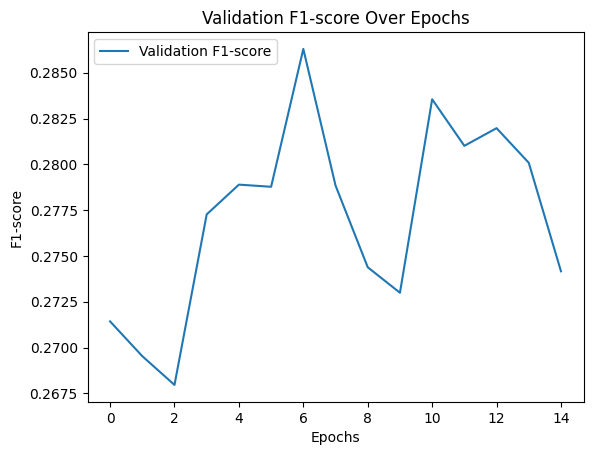

In [68]:
# Plot training and validation accuracy over epochs
plt.plot(all_f1s, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('Validation F1-score Over Epochs')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.show()